# Olga_Poletkina_76426763

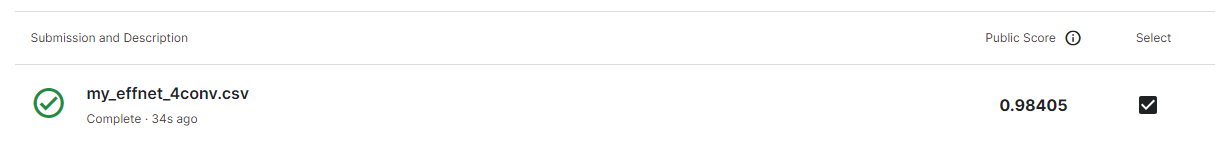

In [1]:
# import gc
# gc.collect()

In [2]:
# !rm -rf ~/.cache/

In [3]:
# !rm -rf /tmp/*

In [4]:
# !df -h

# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [5]:
import shutil

# Delete folders if needed

# shutil.rmtree('folder_name')

In [6]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [7]:
import PIL
print(PIL.__version__)

9.4.0


In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [9]:
!pip install gdown
!gdown --id 14BSPVM_IKClPIV3jMpJyEj1of3QfxCLy

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14BSPVM_IKClPIV3jMpJyEj1of3QfxCLy
To: /content/journey-springfield.zip
100% 546M/546M [00:06<00:00, 82.1MB/s]


In [10]:
!unzip -q /content/journey-springfield.zip

In [11]:
!ls train

simpsons_dataset


In [12]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Nov 14 08:38:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [13]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=2c5747b7aa91feb0ef0ab0e020082d658a4c85573a420a0234c49dac8e64dbb9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [14]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from tqdm import trange
from PIL import Image
from pathlib import Path

from torchvision import transforms
import torchvision.transforms.functional as TF
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder

from matplotlib import colors, pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

from collections import Counter

from efficientnet_pytorch import EfficientNet

# в sklearn не все гладко, чтобы в colab удобно выводить картинки мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [15]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [16]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        # LabelEncoder предназначен для преобразования категориальных меток в числовые значения
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    # Эта строка преобразует тензор PyTorch в массив NumPy и меняет порядок осей.
    # PyTorch использует формат (channels, height, width), но для отображения
    # изображения с помощью matplotlib или других библиотек, требуется формат (height, width, channels).
    # transpose((1, 2, 0)) меняет порядок осей так, чтобы они соответствовали этому требованию.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # Денормализация изображения. Так как изображение было нормализовано
    # (чтобы среднее стало 0 и стандартное отклонение 1),
    # теперь для отображения его необходимо вернуть к исходным значениям.
    # Это делается путем обратной операции нормализации.
    inp = std * inp + mean
    # Эта строка обрезает значения пикселей, чтобы они находились в пределах [0, 1],
    # что необходимо для корректного отображения изображения.
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [18]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [19]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [20]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [21]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [22]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

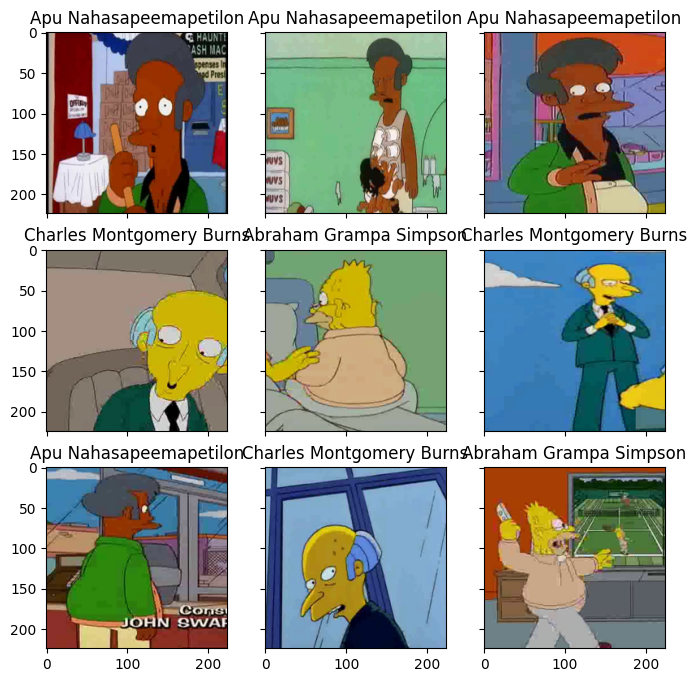

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [24]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [25]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Выбор классов с наибольшими значениями в предсказаниях модели.
        preds = torch.argmax(outputs, 1)
        # Накопление суммарного значения функции потерь, умноженного на размер батча (чтобы в конце получить среднее значение потерь).
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [26]:
%%script false --no-raise-error

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        # Накопление суммарной потери, умноженной на размер батча (для вычисления средней потери)
        running_loss += loss.item() * inputs.size(0)
        # Подсчет общего числа правильных предсказаний модели.
        running_corrects += torch.sum(preds == labels.data)
        # Обновление общего количества обработанных данных.
        processed_size += inputs.size(0)
    # Вычисление средней потери на валидационном наборе данных.
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    # Вычисление точности на валидационном наборе данных. Метод double() используется
    # для преобразования количества правильных предсказаний в тип double для выполнения точного деления.
    return val_loss, val_acc

We  modify the eval_epoch function to return both the predictions and the actual labels for each batch:

In [27]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    all_preds = []
    all_labels = []

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

        all_preds.extend(preds.view(-1).cpu().numpy())
        all_labels.extend(labels.data.view(-1).cpu().numpy())

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc, all_preds, all_labels

In [28]:
%%script false --no-raise-error

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

Update the train function:

In [29]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    all_val_preds = []
    all_val_labels = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc, val_epoch_preds, val_epoch_labels = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            all_val_preds.extend(val_epoch_preds)
            all_val_labels.extend(val_epoch_labels)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history, all_val_preds, all_val_labels


In [30]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [32]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [33]:
train_dataset

In [36]:
# history = train(train_dataset, val_dataset, model=simple_cnn, epochs=3, batch_size=64)

Get predictions and labels from validation dataset

In [37]:
history, val_preds, val_labels = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.4900991948700777


epoch:  50%|█████     | 1/2 [02:21<02:21, 141.13s/it]


Epoch 001 train_loss: 2.4901     val_loss 1.9858 train_acc 0.3151 val_acc 0.4729
loss 1.6311683608541154


epoch: 100%|██████████| 2/2 [04:34<00:00, 137.33s/it]


Epoch 002 train_loss: 1.6312     val_loss 1.4772 train_acc 0.5558 val_acc 0.6022


**Увеличение val_acc (точности на валидационном наборе данных) при одновременном увеличении val_loss может показаться нелогичным, но это вполне возможно и может произойти по нескольким причинам:**

- Неоднородность валидационного набора: Валидационный набор может содержать более легкие или более трудные примеры в разных эпохах. Если в начале валидации модель сталкивается с более сложными примерами, потери могут быть выше, но если позже она сталкивается с более легкими примерами, точность может увеличиться, несмотря на увеличение потерь.

- Метрика точности и функция потерь: Точность — это доля правильных ответов, в то время как потери могут учитывать уверенность модели в этих ответах. Модель может быть менее уверенной в своих предсказаниях (что увеличивает потери), но всё ещё правильно классифицировать больше примеров (что увеличивает точность).

- Неправильные метки: В редких случаях в валидационном наборе могут быть ошибки в метках, и если модель начинает "адаптироваться" к этим ошибкам, это может увеличить потери, но также случайно увеличить точность.

- Функция потерь фокусируется на уверенности: Функции потерь, такие как кросс-энтропия, наказывают модель за избыточную уверенность в неправильных ответах. Если модель начинает становиться менее уверенной в неправильных ответах, потери могут увеличиться, даже если общее количество правильных ответов остаётся прежним или увеличивается.

В целом, хотя точность является важной метрикой, стоит также обращать внимание на другие показатели, такие как потери, F1-мера и AUC-ROC, особенно когда распределение классов несбалансировано или когда важна уверенность предсказаний.

Построим кривые обучения

In [38]:
loss, acc, val_loss, val_acc = zip(*history)

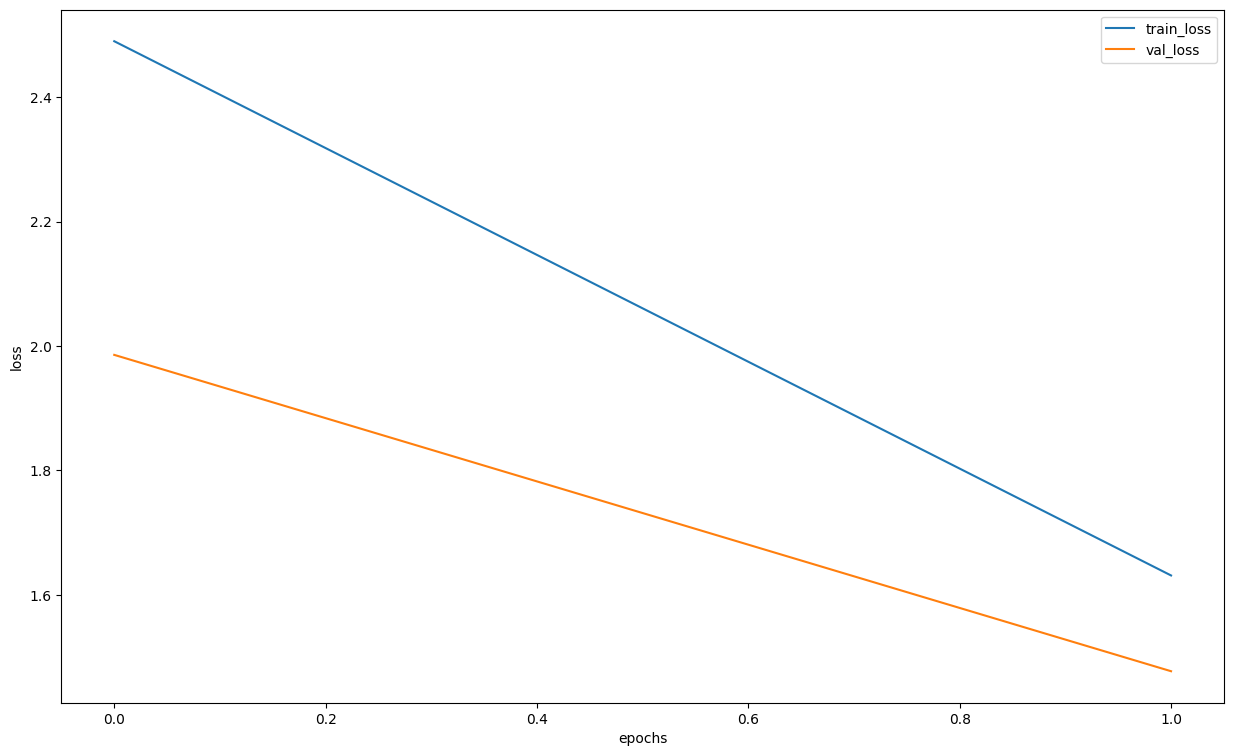

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [40]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [41]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [42]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
# ex_img.unsqueeze(0) — изображение ex_img имеет размерность
# (C, H, W), где C — количество каналов, H — высота и W — ширина. Метод unsqueeze(0)
# добавляет еще одно измерение в начало, преобразуя тензор к размеру (1, C, H, W),
# что необходимо для модели, поскольку она ожидает батч изображений
# (даже если батч содержит только одно изображение).
probs_ims = predict(simple_cnn, imgs)
# Результат работы функции — probs_im — это вероятности принадлежности изображения
# к каждому из классов, предсказанные моделью.

In [43]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [44]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
# pd.DataFrame(actual_labels, preds_class)

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [45]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 0.45


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

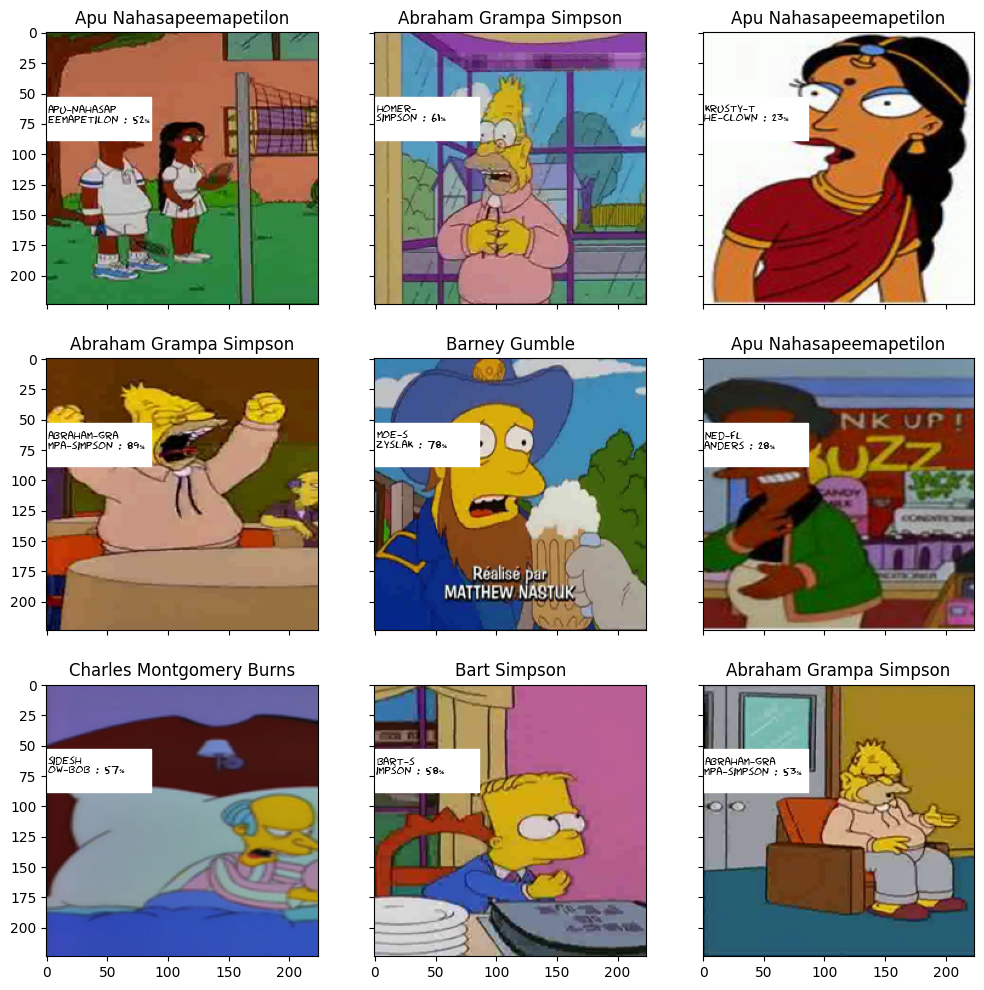

In [46]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [47]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [48]:
! ls

characters_illustration.png  journey-springfield.zip  sample_data	     testset
gdrive			     label_encoder.pkl	      sample_submission.csv  train


In [49]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [50]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [51]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# Class imbalance

### Analyze Class Distribution

In [52]:
# Count the number of images in each class
train_labels = [path.parent.name for path in train_files]
class_counts = Counter(train_labels)

In [53]:
# Extract and Print the Mapping
label_encoder = train_dataset.label_encoder
class_to_num = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
class_to_num_df = pd.DataFrame(list(class_to_num.items()), columns=['Class', 'Label'])
# class_to_num_df

In [54]:
# Creating a DataFrame from the Counter object

# orient='index', means that the keys of the dictionary should be treated as index labels in the DataFrame
# reset_index() method is then used to turn this index into a regular column
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index').reset_index()
class_counts_df.columns = ['Class', 'Count']
class_counts_df = class_counts_df.sort_values('Count', ascending=False)
# class_counts_df

In [55]:
final_df = pd.merge(class_counts_df, class_to_num_df, on='Class')
final_df = final_df.sort_values('Count', ascending=False)
# final_df

### Find the classes that model didn`t manage to predict correctly by creating a confusion matrix

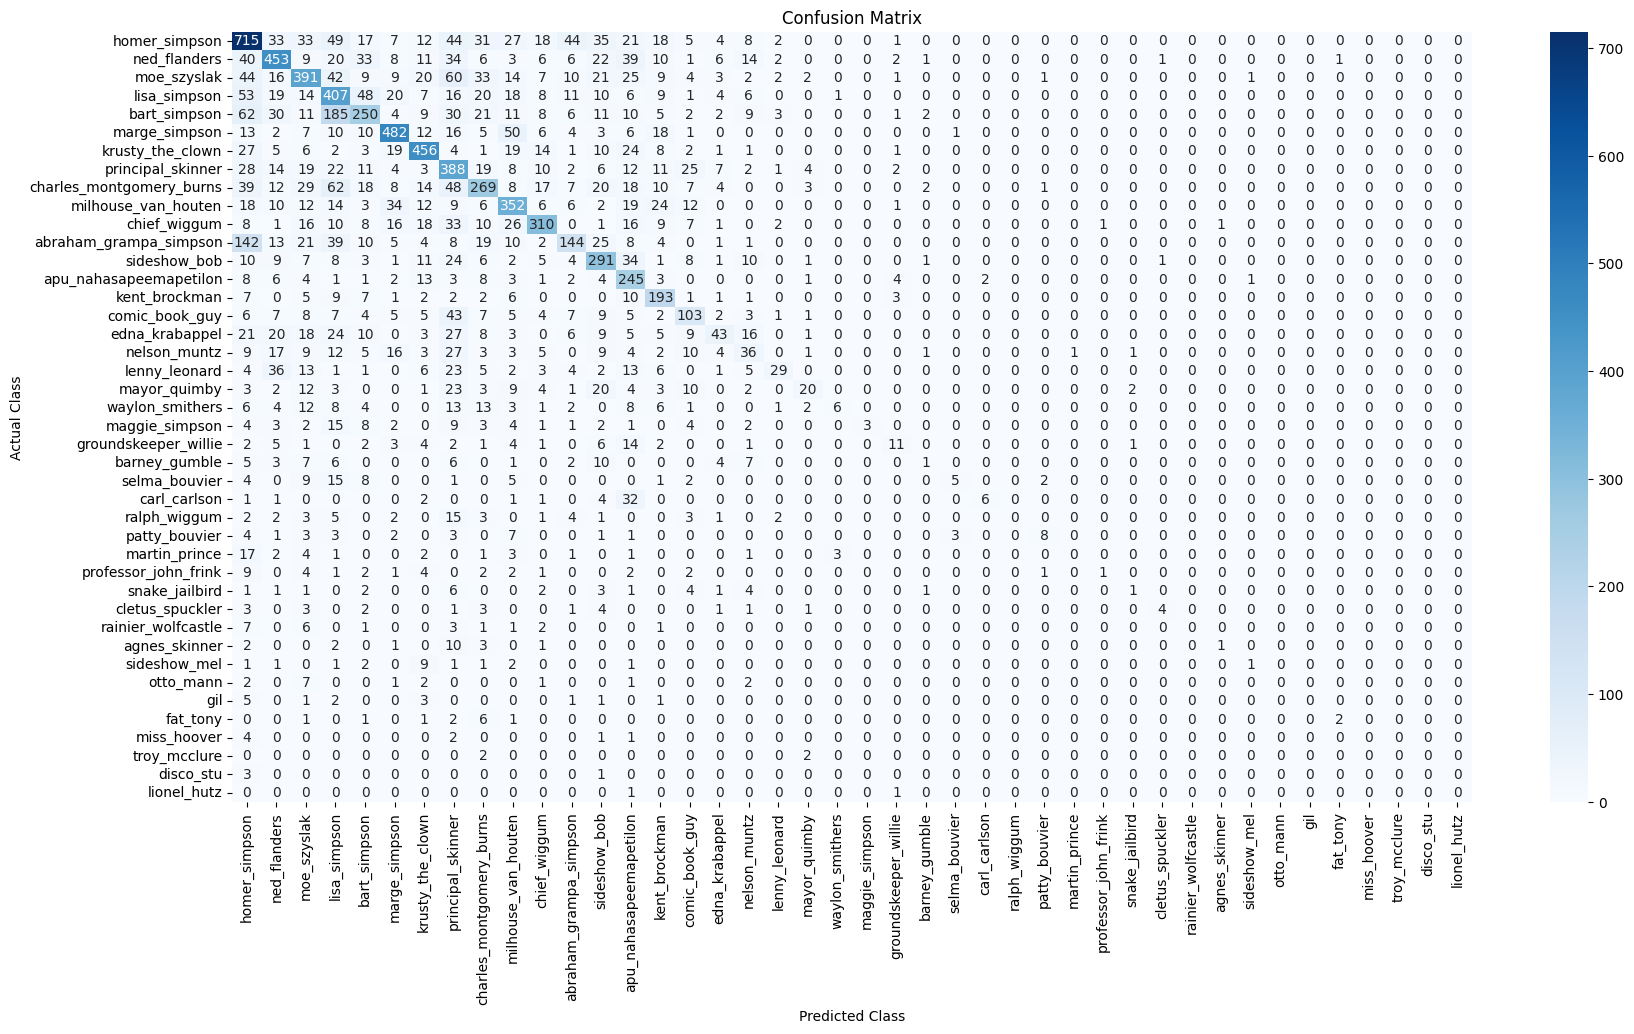

In [56]:
# history, val_preds, val_labels = train(train_dataset, val_dataset, model=simple_cnn, epochs=3, batch_size=64)

# Generate the confusion matrix
sorted_classes = final_df.sort_values('Count', ascending=False)['Class'].tolist()
label_dict = dict(zip(final_df['Class'], final_df['Label']))
sorted_labels = [label_dict[cls] for cls in sorted_classes]

# Create confusion matrix
cm = confusion_matrix(val_labels, val_preds, labels=sorted_labels)

# Sorting the axis labels
sorted_class_names = [label_encoder.classes_[i] for i in sorted_labels]

plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=sorted_class_names, yticklabels=sorted_class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [57]:
# Correct predictions
correct_predictions = np.diag(cm)
# correct_predictions

In [58]:
# Adding correct predictions to the table
final_df['Correct_Predictions'] = correct_predictions

# Calculating presision and recall for each class
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)

# final_df['Precision'] = precision
# final_df['Recall'] = recall
final_df['F1_Score'] = 2 * (precision * recall) / (precision + recall)

<ipython-input-58-125719600a0e>:5: RuntimeWarning: invalid value encountered in divide
  precision = cm.diagonal() / cm.sum(axis=0)
<ipython-input-58-125719600a0e>:10: RuntimeWarning: invalid value encountered in divide
  final_df['F1_Score'] = 2 * (precision * recall) / (precision + recall)


In [59]:
final_df

,Class,Count,Label,Correct_Predictions,F1_Score
0,homer_simpson,1684,15,715,0.580593
1,ned_flanders,1090,28,453,0.622253
2,moe_szyslak,1089,27,391,0.545328
3,lisa_simpson,1015,20,407,0.489183
4,bart_simpson,1006,4,250,0.432900
5,marge_simpson,968,22,482,0.742109
6,krusty_the_clown,904,17,456,0.727853
7,principal_skinner,895,32,388,0.505867
8,charles_montgomery_burns,895,6,269,0.481647
9,milhouse_van_houten,809,25,352,0.610581


# Augmentation

In [60]:
%%script false --no-raise-error

# Creating folders for train and val
train_dir = './train_augmented/'
val_dir = './validation/'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

def copy_files_to_structure(files, target_dir):
    for file_path in files:
        # Get class name from folder name
        class_name = file_path.parent.name
        # Create class folder
        class_dir = os.path.join(target_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        # Copy file to a new folder
        shutil.copy(file_path, os.path.join(class_dir, file_path.name))

# Copy train files
copy_files_to_structure(train_files, train_dir)
# Copy val files
copy_files_to_structure(val_files, val_dir)

In [61]:
small_classes = [class_name for class_name, count in class_counts.items() if count < 1000]
print(len(small_classes))

total_classes = [class_name for class_name, count in class_counts.items()]
print(len(total_classes))

37
42


In [62]:
%%script false --no-raise-error

# Add random noise to a PIL image.
def random_noise(img):
    width, height = img.size
    noise = torch.randn(3, height, width) * 0.1  # Create noise tensor
    noisy_img = transforms.ToTensor()(img) + noise
    return noisy_img.clamp(0, 1)

# Apply augmentations to the image if its label is in small_classes.
def augment_image(image, label, small_classes):
    augmentation_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.Lambda(random_noise)
    ])
    if label in small_classes:
        image = augmentation_transforms(image)

    return image

In [63]:
def save_augmented_images(dataset_dir, small_classes, target_count):

    for class_name in small_classes:
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)
        current_count = len(image_files)

        if current_count >= target_count:
            continue

        # Initialize tqdm progress bar
        with tqdm(total=target_count - current_count, desc=f"Augmenting {class_name}", unit='img') as pbar:
            for i in range(target_count - current_count):
                # Randomly select an image to augment
                image_path = os.path.join(class_dir, random.choice(image_files))
                image = Image.open(image_path).convert('RGB')
                augmented_image = augment_image(image, class_name, small_classes)
                augmented_image_pil = TF.to_pil_image(augmented_image)

                # Save the augmented image
                new_file_name = os.path.join(class_dir, f"aug_{i}_{class_name}.png")
                augmented_image_pil.save(new_file_name)

                # Update the progress bar
                pbar.update(1)

In [64]:
%%script false --no-raise-error

dataset_dir = '/content/train_augmented'
small_classes = [class_name for class_name in os.listdir(dataset_dir)
                 if len(os.listdir(os.path.join(dataset_dir, class_name))) < 1000]

save_augmented_images(dataset_dir, small_classes, 1000)

# Saving augmented data to a drive folder

In [65]:
%%script false --no-raise-error

# save pipe.pkl to output data folder
!cp -r /content/train_augmented /content/gdrive/MyDrive/Colab\ Notebooks/DLS_Stepik/07_CNN_arch_transfer_learning/

In [66]:
%%script false --no-raise-error

!cp -r /content/validation /content/gdrive/MyDrive/Colab\ Notebooks/DLS_Stepik/07_CNN_arch_transfer_learning/

# Preparing Dataset for new model training

In [67]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B1 uses 224x224 input
    transforms.RandomHorizontalFlip(),  # Example of additional augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [68]:
%%script false --no-raise-error

# Load data
train_dataset = ImageFolder(root='./train_augmented/', transform=train_transforms)
val_dataset = ImageFolder(root='./validation/', transform=val_transforms)

In [69]:
# Load data from drive
train_dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/07_CNN_arch_transfer_learning/train_augmented/'
val_dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/DLS_Stepik/07_CNN_arch_transfer_learning/validation/'

train_dataset = ImageFolder(root=train_dataset_path, transform=train_transforms)
val_dataset = ImageFolder(root=val_dataset_path, transform=val_transforms)

In [70]:
num_train_images = len(train_dataset)
print("Number of images in the train dataset:", num_train_images)

Number of images in the train dataset: 42879


In [71]:
# Create DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Load pretrained EfficientNet

In [72]:
# Load pretrained model
model = EfficientNet.from_pretrained('efficientnet-b1')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 193MB/s]


Loaded pretrained weights for efficientnet-b1


In [73]:
# Define the loss function, optimizer, and move model to GPU
# model = model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
# "Freezing" all layers
for param in model.parameters():
    param.requires_grad = False

# "Unfreezing" the last few convolutional blocks
for param in model._blocks[-4:].parameters():
    param.requires_grad = True

# "Unfreezing" all linear layers (classifiers)
for param in model._fc.parameters():
    param.requires_grad = True

# Features number (_fc goes for classifier, linear layers in EfficientNet classifier)
num_features = model._fc.in_features

# Change output layer from 1000 to dataset number
model._fc = nn.Linear(num_features, len(total_classes))

# Multiplies the learning_rate by 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# MyTrain loop

In [75]:
def my_train(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=10):
    model.to(DEVICE)

    # Saving best model weights
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)
        for batch_idx, (images, labels) in enumerate(train_progress):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # Resets the gradients in the optimizer before computing the loss and gradients for the current batch.
            optimizer.zero_grad()
            # Feeds the batch of images through the model to get predictions.
            outputs = model(images)
            # Computes the loss between the model's predictions and the actual labels.
            loss = criterion(outputs, labels)
            # Computes the gradients of the loss with respect to model parameters.
            loss.backward()
            # Updates the model parameters based on the computed gradients.
            optimizer.step()

            # loss.item() extracts loss value as float, image.size(0) - gets the batch size,
            # by mult. two numbers we get total loss for batch and add it to running loss, that collects a a total loss for all batches
            running_loss += loss.item() * images.size(0)
            # gets the class predicted
            _, predicted = torch.max(outputs.data, 1)
            # gets the batch size, similar to images.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculates and prints the average loss and accuracy for the training dataset at the end of each epoch.
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct / total

        train_progress.set_description(f'Epoch {epoch+1}/{epochs} [Train] Loss: {running_loss/(batch_idx+1):.4f}, Accuracy: {train_accuracy:.2f}%')

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        val_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Validation]', leave=False)
        # Disables gradient computation for efficiency, as gradients are not needed in validation.
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_progress):
                # Processes each validation batch similarly to the training batches, but without updating model parameters.
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Check if this is the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()
        # Step the scheduler
        scheduler.step()

    print('Finished Training')

    return best_model_wts

In [77]:
best_weights = my_train(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs=3)

Epoch 1/5, Train Loss: 0.3636, Train Accuracy: 94.44%


Epoch 1/5, Val Loss: 1.1836, Val Accuracy: 98.55%


Epoch 2/5, Train Loss: 0.2115, Train Accuracy: 96.69%


Epoch 2/5, Val Loss: 0.7676, Val Accuracy: 99.20%


Epoch 3/5, Train Loss: 0.1576, Train Accuracy: 97.60%


Epoch 3/5, Val Loss: 0.5004, Val Accuracy: 99.39%


Epoch 4/5, Train Loss: 0.1247, Train Accuracy: 98.16%


Epoch 4/5, Val Loss: 0.3880, Val Accuracy: 99.54%


Epoch 5/5, Train Loss: 0.1101, Train Accuracy: 98.42%


Epoch 5/5, Val Loss: 0.3690, Val Accuracy: 99.67%
Finished Training


# Save tuned model and run on testset

In [78]:
# Save the best model weights to a file
torch.save(best_weights, 'best_model_effnet_4conv_5epochs.pth')

In [80]:
!cp -r /content/best_model_effnet_4conv_5epochs.pth /content/gdrive/MyDrive/Colab\ Notebooks/DLS_Stepik/07_CNN_arch_transfer_learning/

In [81]:
# Recreate the model and load the saved weights
# model = EfficientNet.from_pretrained('efficientnet-b1') # pick correct architecture
model.load_state_dict(torch.load('best_model_effnet_4conv_5epochs.pth')) # load saved weights
model.eval() # Set to evaluation mode

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [89]:
all_predictions = []
all_true_labels = []

model.to(DEVICE)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Calculate F1 Score
f1 = f1_score(all_true_labels, all_predictions, average='macro')
print("F1 Score:", f1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


F1 Score: 0.8566998601072141


In [83]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

# print(preds)

In [84]:
my_submit = pd.read_csv("/content/sample_submission.csv")
correct_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
correct_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [85]:
my_submit = pd.DataFrame({'id': test_filenames, 'Expected': preds})

In [86]:
my_submit.to_csv('my_effnet_4conv_5epochs.csv', index=False)

In [88]:
!cp -r /content/my_effnet_4conv_5epochs.csv /content/gdrive/MyDrive/Colab\ Notebooks/DLS_Stepik/07_CNN_arch_transfer_learning/